In [1]:
from google.colab import drive 
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/kds/1sem/ditw/ditw_project')

Mounted at /content/drive


In [2]:
!pip install sentence_transformers
!pip install hdbscan
!pip install umap-learn
!pip install matplotlib
!pip install pandas

     |████████████████████████████████| 78 kB 4.7 MB/s 
     |████████████████████████████████| 3.1 MB 27.7 MB/s 
     |████████████████████████████████| 3.3 MB 39.9 MB/s 
     |████████████████████████████████| 1.2 MB 35.8 MB/s 
     |████████████████████████████████| 61 kB 492 kB/s 
     |████████████████████████████████| 895 kB 39.9 MB/s 
     |████████████████████████████████| 596 kB 41.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=a74b07196fe258899fc8f20ee010f96e5d69f1b419d22c7930004cb769db0ac0
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 6.4 MB 8.9 MB/s 
  Installing build dependencies ... done
  Getting requirements

In [1]:
# Imports
from src.json_utils import read_jsonl
from src.config import DATA_DIR
import pandas as pd
import os
from src.preprocessing import *

In [3]:
data = read_jsonl('../data/dkpol_tweets.jsonl')

Reading ../data/dkpol_tweets.jsonl


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92778 entries, 0 to 92777
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  92778 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 725.0 KB


/Users/hrmussa/.pyenv/versions/3.8.9/envs/ditw/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:xlabel='timestamp'>

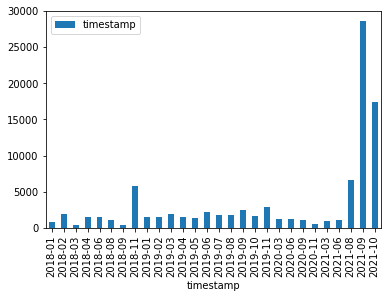

In [4]:
df = pd.DataFrame([i['created_at'] for i in data], columns=['timestamp'])
df.timestamp = pd.to_datetime(df.timestamp)
df.info()
df[['timestamp', ]].groupby(df.timestamp.dt.to_period("M")).agg('count').plot(kind='bar')



In [6]:
df[['timestamp', ]].groupby(df.timestamp.dt.to_period("M")).agg('count')

/Users/hrmussa/.pyenv/versions/3.8.9/envs/ditw/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,timestamp
timestamp,
2018-01,801
2018-02,1956
2018-03,379
2018-04,1502
2018-06,1541
2018-08,1056
2018-09,444
2018-11,5752
2019-01,1533


In [ ]:
df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
sub = df[['created_at', 'text']].groupby(df.created_at.dt.to_period("M")).head(20000)

<AxesSubplot:xlabel='created_at'>

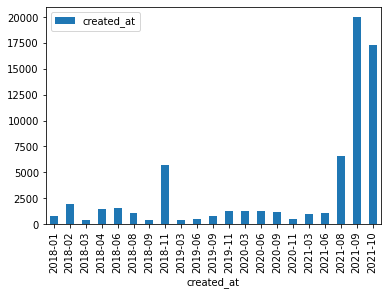

In [ ]:
sub[['created_at']].groupby(df.created_at.dt.to_period("M")).agg('count').plot(kind='bar')

### Embedding Methods

**Resources**
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

### Td-idf

In [4]:
# Imports 

import spacy
from src.config import DATA_DIR
from src.json_utils import read_jsonl
from src.preprocessing import *
import re
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pylab as plt
from sentence_transformers import SentenceTransformer
import seaborn as sns
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from tqdm import tqdm

In [ ]:
# Define util functions

with open('../data/danish_stopwords.txt') as stop_file:
    stopwords = [word.strip() for word in stop_file.readlines()]


def remove_newlines(text: str) -> str:
    return re.sub(r'\n+', ' ', text)


def normalize_spaces(text: str) -> str:
    return re.sub(r'\s{2,}', ' ', text)


def remove_punctuation(text: str) -> str:
    return re.sub('[:,\\.!?\'\"\\”\\(\\)\\/\\-]', '', text)


def is_website_token(token: str) -> str:
    if token[:4] == 'http':
        return ''
    else:
        return token

# def cosine_similarity(matrix):
#     norm = pd.DataFrame(np.sqrt(np.square(matrix).sum(axis = 0)))
#     denominator = norm.dot(norm.T)
#     numerator = matrix.dot(matrix.T)
#     similarity_matrix = numerator.divide(denominator,axis =1)
#     return similarity_matrix

In [ ]:
# Prepare data for embedding

preprocessing_func = [remove_punctuation, str.lower, is_website_token]

tweet_tokenizer = TweetTokenizer()

data = read_jsonl('../data/dkpol_tweets.jsonl')

df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
sub = df[['created_at', 'text']].groupby(df.created_at.dt.to_period("M")).head(350)
text = list(sub['text'].values)
tokenized_text = [[token for token in tweet_tokenizer.tokenize(i) if token not in stopwords] for i in text]

all_tokenizer_text = []

for text in tokenized_text:
    post_precessed = []
    for token in text:
        for function in preprocessing_func:
            token = function(token)
        if token != '':
            post_precessed.append(token)
    all_tokenizer_text.append(' '.join(post_precessed))

Reading ../data/dkpol_tweets.jsonl


/Users/hrmussa/.pyenv/versions/3.8.9/envs/ditw/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [ ]:
vectorizer = TfidfVectorizer(tokenizer = TweetTokenizer().tokenize, max_features=5000, stop_words=None, ngram_range=(1, 3), min_df=10, max_df=0.85)
X = vectorizer.fit_transform(all_tokenizer_text)
print(X.shape)

(7350, 2494)


In [ ]:
# Get all pairwise cosine similarities

A_sparse = sparse.csr_matrix(X)

#also can output sparse matrices
similarities_sparse = cosine_similarity(A_sparse,dense_output=False)
#print('pairwise sparse output:\n {}\n'.format(similarities_sparse))
similarities_sparse

<7350x7350 sparse matrix of type '<class 'numpy.float64'>'
	with 6503408 stored elements in Compressed Sparse Row format>

In [ ]:
# Get all pairs of cosine similarities above 0

dict_of_similarities = {}
x, y = similarities_sparse.nonzero()[0], similarities_sparse.nonzero()[1] 
for i, j in tqdm(zip(x,y)):
    if (i, j) not in dict_of_similarities and(j, i) not in dict_of_similarities and round(similarities_sparse[i, j], 5) != 1:
        dict_of_similarities[(i, j)] = similarities_sparse[i, j]

print(len(dict_of_similarities))

6503408it [02:05, 51890.24it/s] 

3242141


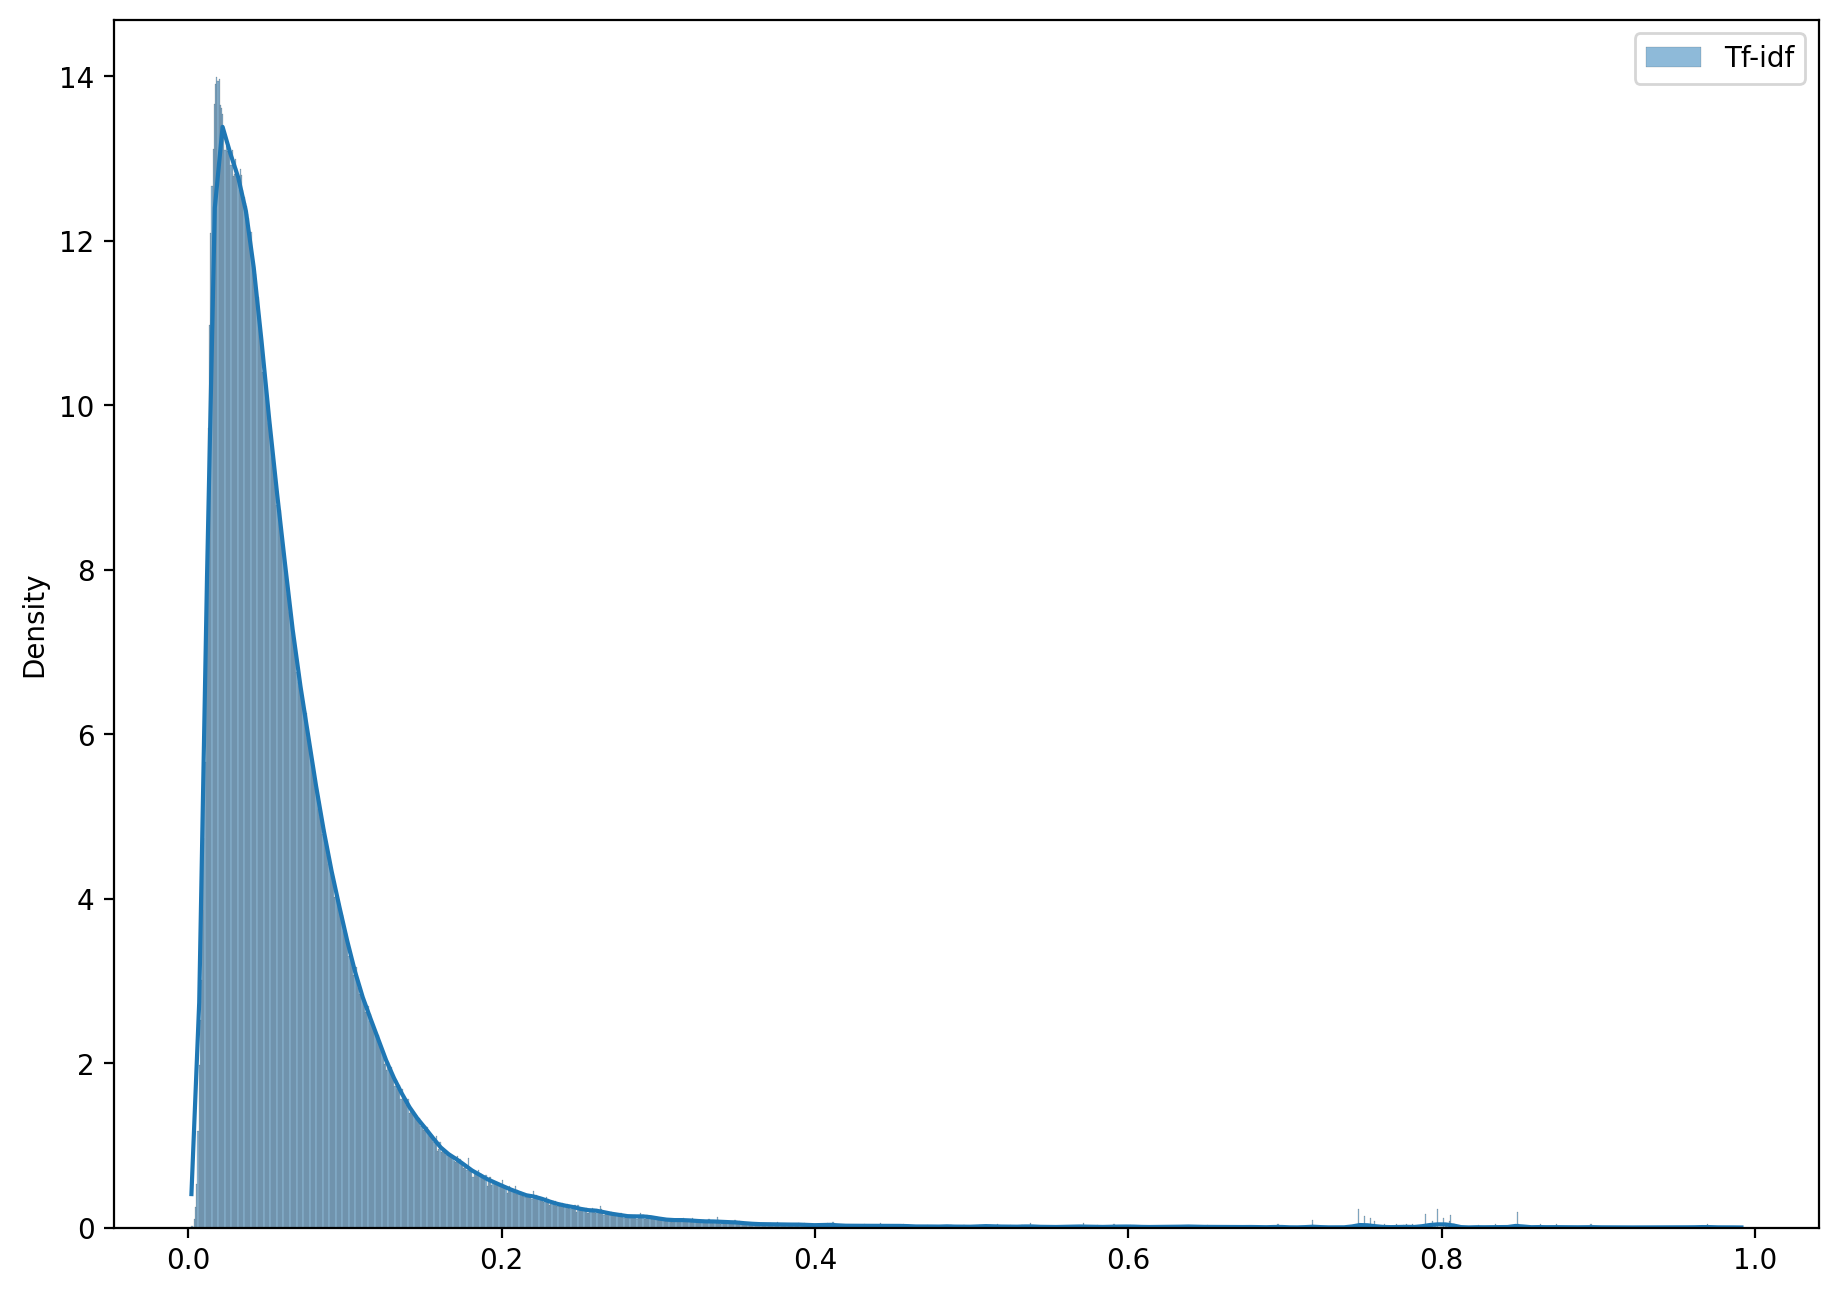

In [ ]:
# Plot
#kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(11,8), dpi= 200)
#sns.distplot(list(dict_of_similarities.values()), color="dodgerblue", label="Td-idf", **kwargs)
sns.histplot(list(dict_of_similarities.values()), stat='density', kde=True, label = 'Tf-idf')
plt.legend()
plt.savefig('../data/img/tf_ifd_cossim_dist.png')
plt.show()

In [ ]:
len(text)

27

In [ ]:
for idx_t, val in dict_of_similarities.items():
    if val >  0.6 and val < 1.0:
        one, two = idx_t
        print(all_tokenizer_text[one])
        print(all_tokenizer_text[two])
        print(val)
        print('----------------------')

### Ælæctra / BERT

In [5]:
# Prepare data
data = read_jsonl('data/dkpol_tweets.jsonl')
df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
sub = df[['created_at', 'text']].groupby(df.created_at.dt.to_period("M")).head(350)
text = list(sub['text'].values)
text = replace_url(text)
len(text)

Reading data/dkpol_tweets.jsonl


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


7350

In [7]:
# Embed texts
encoder = SentenceTransformer('Maltehb/danish-bert-botxo')
embeddings = encoder.encode(text, show_progress_bar=True, normalize_embeddings = True)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/Maltehb_danish-bert-botxo were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/230 [00:00<?, ?it/s]

In [8]:
A_sparse = sparse.csr_matrix(embeddings)

#also can output sparse matrices
similarities_sparse = cosine_similarity(A_sparse,dense_output=False)
#print('pairwise sparse output:\n {}\n'.format(similarities_sparse))
similarities_sparse

<7350x7350 sparse matrix of type '<class 'numpy.float32'>'
	with 54022500 stored elements in Compressed Sparse Row format>

In [9]:
# Get all pairs of cosine similarities above 0

dict_of_similarities = {}
x, y = similarities_sparse.nonzero()[0], similarities_sparse.nonzero()[1] 
for i, j in tqdm(zip(x,y)):
    if (i, j) not in dict_of_similarities and(j, i) not in dict_of_similarities and round(similarities_sparse[i, j], 5) != 1:
        dict_of_similarities[(i, j)] = similarities_sparse[i, j]

print(len(dict_of_similarities))

54022500it [43:37, 20636.49it/s] 

27005400


In [ ]:
plt.figure(figsize=(12,9), dpi= 300)
#sns.distplot(list(dict_of_similarities.values()), color="dodgerblue", label="Td-idf", **kwargs)
sns.histplot(list(dict_of_similarities.values()), stat='density', kde=True, label = 'Danish BERT')
plt.legend()
plt.tight_layout()
plt.savefig('data/img/bert_cossim_dist.png')
plt.show()

In [ ]:
dict_of_similarities
print(text[0])
print()
print(text[7154])

Det er på tide køreprøver kommer i konkurrence og på private hænder. Ligesom med bilsyn. Væk med ventetider og styrket kvaliteten. #dkpol  URL

@Fiscker89 @MortenDDHansen @DRNyheder Og der er spørgsmålet så, er det rimeligt at folk i vest Jylland skal være bange for at sende deres børn ud at lege? Ligegyldigt hvor ubegrundet frygten er, så er folk der bor der, utrygge ved at have Ulve som naboer! #dkpol


### DaCy Model

In [ ]:
# import spacy

import dacy
nlp = dacy.load("da_dacy_small_trf-0.1.0")
for doc in nlp.pipe(["Det her er en sjovt text", "Fodbold er rigtig kedeligt"]):
    tokvecs = doc._.trf_data.tensors[-1]
    print(tokvecs.shape)

# some_embeddings = np.vstack([doc._.trf_data.tensors[-1] for doc in tqdm(nlp.pipe(text))])

(1, 8, 256)
(1, 8, 256)


In [ ]:
A_sparse = sparse.csr_matrix(some_embeddings)

#also can output sparse matrices
similarities_sparse = cosine_similarity(A_sparse,dense_output=False)
#print('pairwise sparse output:\n {}\n'.format(similarities_sparse))
similarities_sparse

<2x2 sparse matrix of type '<class 'numpy.float32'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
# Get all pairs of cosine similarities above 0

dict_of_similarities = {}
x, y = similarities_sparse.nonzero()[0], similarities_sparse.nonzero()[1] 
for i, j in tqdm(zip(x,y)):
    if (i, j) not in dict_of_similarities and(j, i) not in dict_of_similarities and round(similarities_sparse[i, j], 5) != 1:
        dict_of_similarities[(i, j)] = similarities_sparse[i, j]

print(len(dict_of_similarities))

4it [00:00, 9686.61it/s]

1


In [ ]:
dict_of_similarities

{(0, 1): -0.2148652}